In [1]:
from io import BytesIO

import jax
import jax.numpy as jnp
import numpy as np
import pax
import requests
import torch
import torchvision
from PIL import Image, ImageDraw

from pretrained_resnet18 import IMAGENET_MEAN, IMAGENET_STD, load_pretrained_resnet18

pax.seed_rng_key(42)

In [2]:
resnet18 = load_pretrained_resnet18()
resnet18_pt = torchvision.models.resnet18(pretrained=True).eval()

In [3]:
def test_resnet(resnet18, resnet18_pt):
    """check if the predicted logits of the two networks on random inputs are the same."""
    img = jax.random.normal(jax.random.PRNGKey(11), (16, 3, 224, 224))
    a = resnet18_pt(torch.from_numpy(np.copy(jax.device_get(img)))).data.numpy()

    b = jax.device_get(resnet18(img))
    assert jnp.max(jnp.abs(b - a)).item() < 1e-5


test_resnet(resnet18, resnet18_pt)

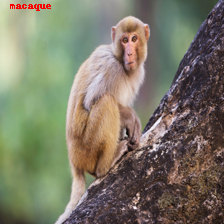

In [4]:
def test_real_image_prediction(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).resize([350, 224])
    img = img.resize((224, 224))
    img224 = np.array(img).astype(np.float32) / 255.0
    img224 = (img224 - IMAGENET_MEAN[None, None, :]) / IMAGENET_STD[None, None, :]
    img224 = jnp.transpose(img224, axes=(2, 0, 1))[None]
    labels = (
        requests.get(
            "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
        )
        .content.decode("utf-8")
        .split("\n")
    )
    logits = resnet18(img224)
    predicted_label = labels[jnp.argmax(logits, axis=-1).item()]
    logits_pt = resnet18_pt(torch.from_numpy(np.copy(img224)))
    assert jnp.max(jnp.abs(logits - logits_pt.data.numpy())) < 1.1e-5
    ImageDraw.Draw(img).text(
        (10, 0),
        predicted_label,
        (255, 0, 0),
    )
    return img


test_real_image_prediction(
    "https://static.scientificamerican.com/sciam/cache/file/381CAC9C-0218-4E87-A9495AB3B0057912_source.png?w=590&h=800&C58484F3-9096-4905-98A3DF50A97807CF"
)